In [1]:
import numpy as np
import healpy as hp
import astropy.io.fits as pyfits
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import os
import ROOT
ROOT.gSystem.Load("/nevis/tehanu/data/st3624/software/GRAMS/GramsSim-work/libDictionary.so")

plt.style.use('~/latex-cm.mplstyle')


import seaborn as sns
colors = sns.color_palette('colorblind')

In [2]:
# info about which sim we are working with
location = 'tucson'
date = '2025_8_31'
maps_dir = f'/nevis/tehanu/data/st3624/software/GRAMS/GramsOccupancy/{location}_{date}_maps'

In [3]:
# load in g4 output files for all particles
particle_dict = {'neutro':['Neutron', '2112'], 'proton':['Proton', '2212'], 'he---4':['Helium-4','1000020040'], 'muplus':['$\\mu^+$','-13'], 'mumins': ['$\\mu^-$','13'], 'electr':['Electron', '11'], 'positr':['Positron', '-11'], 'photon': ['Photon', '22']}

In [4]:
def load_particle_trees(location, particles, maps_dir, tree_name="gramsg4"):
    files = {}
    trees = {}

    for p in particles:
        path = f"{maps_dir}/sim/{location}_{p}_g4.root"
        f = ROOT.TFile.Open(path)
        if not f or f.IsZombie():
            print(f"[WARN] Failed to open: {path}")
            files[p] = None
            trees[p] = None
            continue

        # fetch by file handle
        t = f.Get(tree_name)
        if not t or not isinstance(t, ROOT.TTree):
            print(f"[WARN] '{tree_name}' not found or not a TTree in: {path}")
            files[p] = f
            trees[p] = None
            continue

        print(f"[OK] {p:>6}: {tree_name} with {t.GetEntries()} entries from {path}")
        files[p] = f
        trees[p] = t

    return files, trees


In [5]:
files, trees = load_particle_trees(location, particle_dict.keys(), maps_dir)

[OK] neutro: gramsg4 with 10000 entries from /nevis/tehanu/data/st3624/software/GRAMS/GramsOccupancy/tucson_2025_8_31_maps/sim/tucson_neutro_g4.root
[OK] proton: gramsg4 with 10000 entries from /nevis/tehanu/data/st3624/software/GRAMS/GramsOccupancy/tucson_2025_8_31_maps/sim/tucson_proton_g4.root
[OK] he---4: gramsg4 with 10000 entries from /nevis/tehanu/data/st3624/software/GRAMS/GramsOccupancy/tucson_2025_8_31_maps/sim/tucson_he---4_g4.root
[OK] muplus: gramsg4 with 10000 entries from /nevis/tehanu/data/st3624/software/GRAMS/GramsOccupancy/tucson_2025_8_31_maps/sim/tucson_muplus_g4.root
[OK] mumins: gramsg4 with 10000 entries from /nevis/tehanu/data/st3624/software/GRAMS/GramsOccupancy/tucson_2025_8_31_maps/sim/tucson_mumins_g4.root
[OK] electr: gramsg4 with 10000 entries from /nevis/tehanu/data/st3624/software/GRAMS/GramsOccupancy/tucson_2025_8_31_maps/sim/tucson_electr_g4.root
[OK] positr: gramsg4 with 10000 entries from /nevis/tehanu/data/st3624/software/GRAMS/GramsOccupancy/tucso

In [7]:
import ROOT
from collections import defaultdict

# list of primary energies for each process
energies_by_process = defaultdict(list)

tree = trees["photon"]

for entry in tree:
    # find primary track ID and energy, assuming a single primary
    primary_id = None
    primary_E0 = None

    for trackID, track in tree.TrackList:
        if track.Process() == "Primary":
            primary_id = trackID
            traj = track.Trajectory()
            if len(traj) > 0:
                primary_E0 = traj[0].momentum.E()
            break

    if primary_id is None or primary_E0 is None:
        continue

    # collect TrackIDs that produced MCLArHits in this event
    hit_trackIDs = set()
    for key, _ in tree.LArHits:
        # key is std::tuple<int,int> (trackID, hitID)
        try:
            tid = ROOT.std.get[0](key)
        except TypeError:
            tid = ROOT.std.get(key, 0)
        hit_trackIDs.add(tid)

    # choose whether or not you want daughters that produced hits
    has_primary_daughter_hit = False

    # prevent double counting per process for this primary in this event
    counted_processes = set()

    # find secondary tracks that are direct daughters of the primary
    for trackID, track in tree.TrackList:
        if trackID == primary_id:
            continue # now we skip primaries
        
        # save only daughters of the primary
        try:
            parent_id = track.ParentID()
        except Exception:
            parent_id = None

        if parent_id != primary_id:
            continue

        # require that this daughter produced at least one hit
        if trackID not in hit_trackIDs:
            continue

        has_primary_daughter_hit = True

        # If you kept the gate and no daughter had hits, you could skip storing anything for this event
        if not has_primary_daughter_hit:
            continue
        
        # save creation mechanism of this daughter
        label = track.Process() or "UnknownCreation"

        # store the primary energy (not the daughter’s)
        if label not in counted_processes:
            energies_by_process[label].append(primary_E0)
            counted_processes.add(label)

In [7]:
import ROOT
import numpy as np
from collections import defaultdict

# Configuration
all_particles_to_process = [
    'photon', 'proton', 'he---4', 'neutro', 
    'muplus', 'mumins', 'electr', 'positr'
]

def extract_data_for_particle(tree):
    """
    Extracts dictionary of {label: [energies]} for a single tree.
    Logic: Direct Daughters Only, Distinct processes per event.
    """
    energies_by_process = defaultdict(list)
    
    if not tree:
        return energies_by_process

    for entry in tree:
        # 1. Find Primary
        primary_id = None
        primary_E0 = None
        for trackID, track in tree.TrackList:
            if track.Process() == "Primary":
                primary_id = trackID
                traj = track.Trajectory()
                if len(traj) > 0:
                    primary_E0 = traj[0].momentum.E()
                break

        if primary_id is None or primary_E0 is None:
            continue

        # 2. Collect Hit TrackIDs
        hit_trackIDs = set()
        for key, _ in tree.LArHits:
            try:
                tid = ROOT.std.get[0](key)
            except TypeError:
                tid = ROOT.std.get(key, 0)
            hit_trackIDs.add(tid)

        # 3. Filter Daughters
        counted_processes = set()
        
        for trackID, track in tree.TrackList:
            if trackID == primary_id: continue 

            # Direct Daughter Check
            try: pid = track.ParentID()
            except: pid = None
            if pid != primary_id: continue

            # Hit Check
            if trackID not in hit_trackIDs: continue

            # Store unique process
            label = track.Process() or "UnknownCreation"
            if label not in counted_processes:
                energies_by_process[label].append(primary_E0)
                counted_processes.add(label)
                
    return energies_by_process

# --- Main Execution Loop ---
print("Starting Data Extraction...")
processed_data = {}

for p in all_particles_to_process:
    if p in trees:
        print(f"Extracting data for {p}...")
        processed_data[p] = extract_data_for_particle(trees[p])
    else:
        print(f"Skipping {p} (Tree not found)")
        processed_data[p] = {}

print("Extraction Complete.")


Starting Data Extraction...
Extracting data for photon...
Extracting data for proton...
Extracting data for he---4...
Extracting data for neutro...
Extracting data for muplus...
Extracting data for mumins...
Extracting data for electr...
Extracting data for positr...
Extraction Complete.


In [9]:
output_filename = "processbyenergy.pkl"

print(f"Saving processed data to {output_filename}...")
with open(output_filename, "wb") as f:
    pickle.dump(processed_data, f)
print("Save complete!")

Saving processed data to processbyenergy.pkl...
Save complete!


In [12]:
input_filename = "processbyenergy.pkl"

if os.path.exists(input_filename):
    print(f"Loading data from {input_filename}...")
    with open(input_filename, "rb") as f:
        processed_data = pickle.load(f)
    print(f"Load complete! Loaded particles: {list(processed_data.keys())}")
else:
    print(f"Error: {input_filename} not found. You must run the extraction script first.")
    processed_data = {}

Loading data from processbyenergy.pkl...
Load complete! Loaded particles: ['photon', 'proton', 'he---4', 'neutro', 'muplus', 'mumins', 'electr', 'positr']


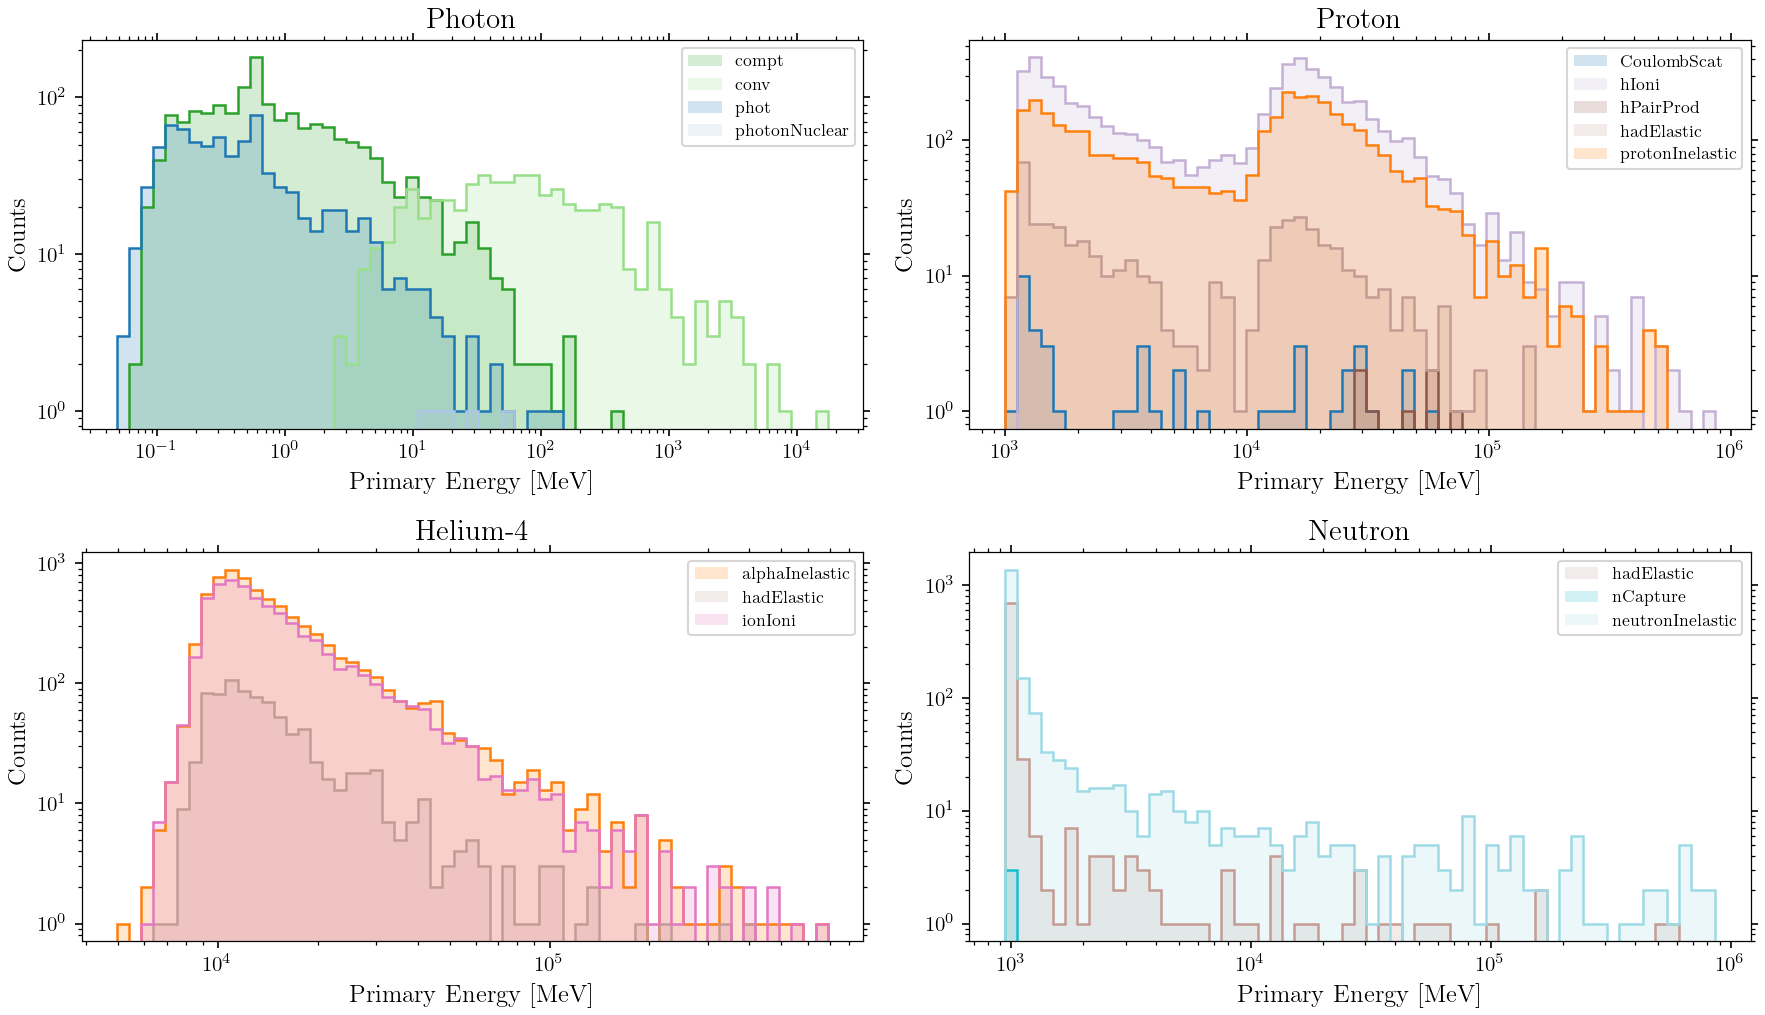

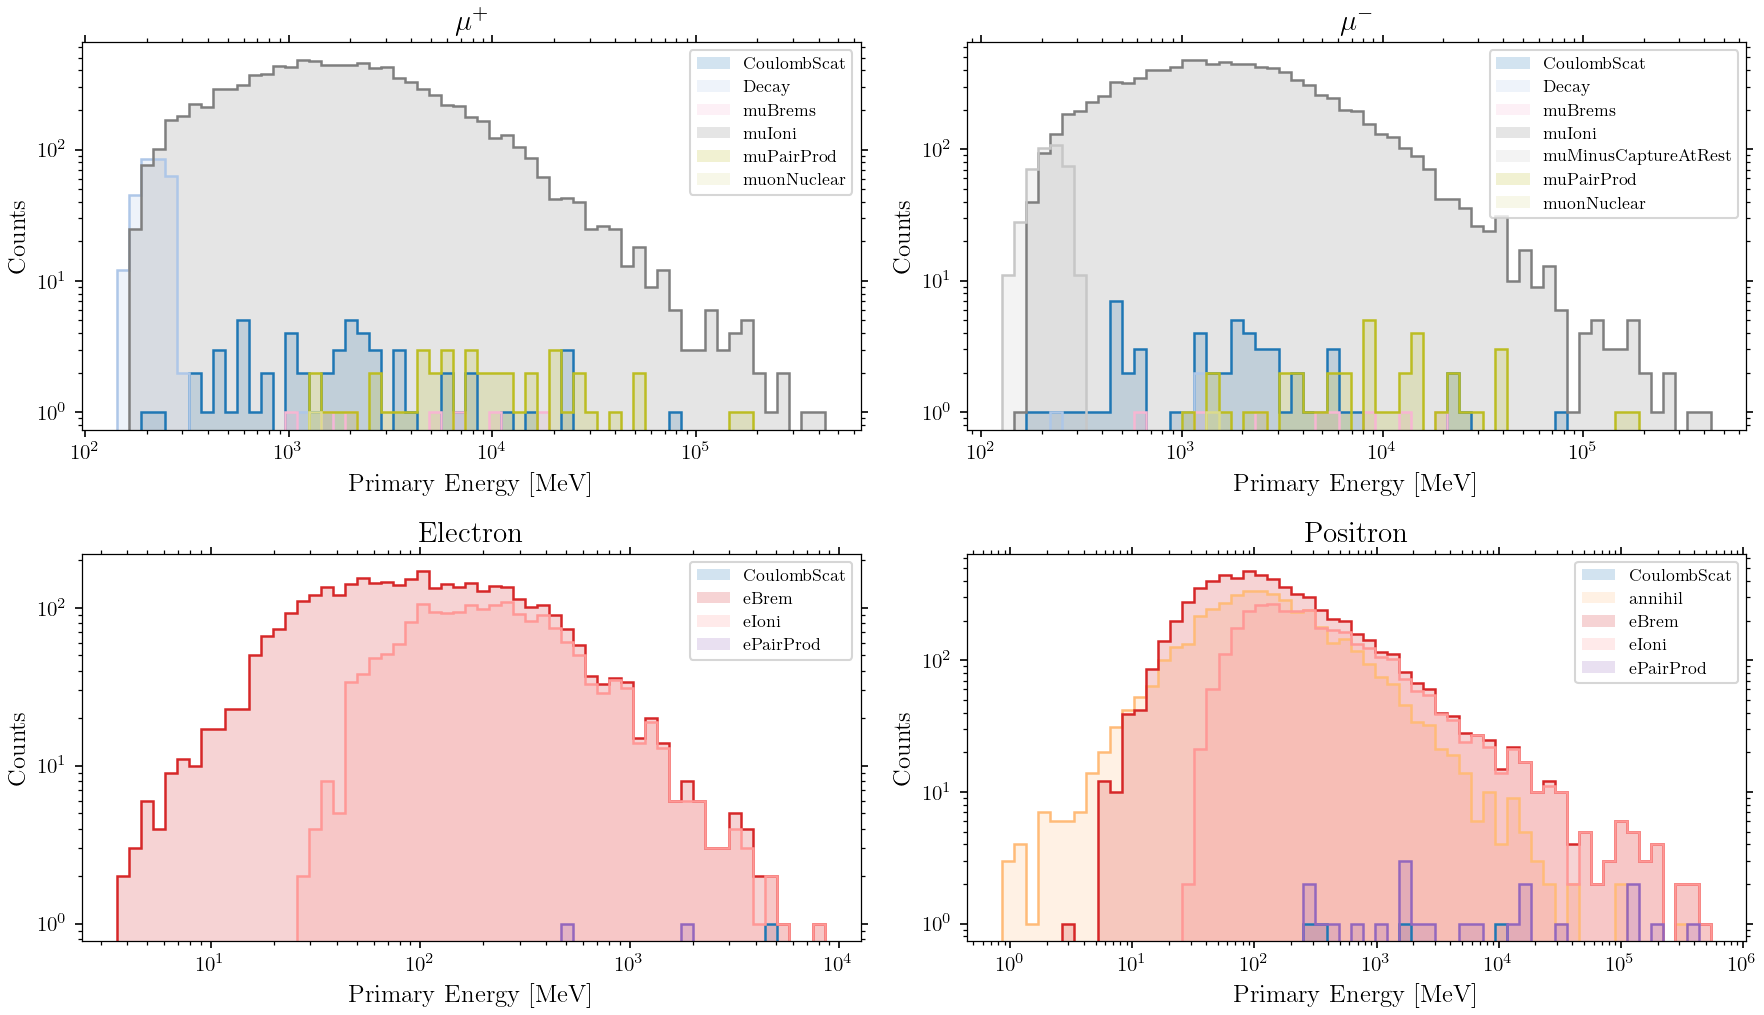

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Groups
group1 = ['photon', 'proton', 'he---4', 'neutro']
group2 = ['muplus', 'mumins', 'electr', 'positr']

particle_names = {
    'neutro': 'Neutron', 'proton': 'Proton', 'he---4': 'Helium-4',
    'muplus': r'$\mu^+$', 'mumins': r'$\mu^-$', 'electr': 'Electron',
    'positr': 'Positron', 'photon': 'Photon'
}

# --- 1. Build Global Color Map ---
# We use tab20 because it offers more distinct colors than tab10
all_labels = set()
for p_data in processed_data.values():
    all_labels.update(p_data.keys())

# Sort labels so the color assignment is deterministic
sorted_labels = sorted(list(all_labels))
color_cycle = plt.cm.tab20.colors 

# Map each label to a specific color
label_to_color = {
    label: color_cycle[i % len(color_cycle)] 
    for i, label in enumerate(sorted_labels)
}

# --- 2. Plotting Function ---
def make_grid_plot(particle_list, data_source, title):
    """
    Creates a 2x2 grid from pre-processed data with consistent coloring.
    """
    fig, axes = plt.subplots(2, 2, figsize=(12, 7))
    axes = axes.flatten()

    for ax, p in zip(axes, particle_list):
        data_dict = data_source.get(p, {})
        
        # Handle empty/missing data
        if not data_dict:
            ax.text(0.5, 0.5, "No Data", ha='center', transform=ax.transAxes)
            ax.set_title(particle_names.get(p, p))
            continue

        labels = sorted(data_dict.keys())
        
        # Prepare arrays for plotting
        plot_data = []
        all_energies = []
        
        for l in labels:
            arr = np.asarray(data_dict[l], dtype=float)
            # Basic cleaning
            arr = arr[np.isfinite(arr) & (arr > 0.0)]
            plot_data.append(arr)
            if arr.size > 0:
                all_energies.append(arr)

        if not all_energies:
            ax.text(0.5, 0.5, "No Events", ha='center', transform=ax.transAxes)
            ax.set_title(particle_names.get(p, p))
            continue

        # Dynamic Binning based on all data in this subplot
        flat_E = np.concatenate(all_energies)
        emin = max(np.min(flat_E), 1e-2)
        emax = np.max(flat_E)
        bins = np.geomspace(emin, emax, 60)

        # Draw Histograms
        for label, Es in zip(labels, plot_data):
            if Es.size == 0: continue
            
            # LOOK UP COLOR FROM GLOBAL MAP
            this_color = label_to_color.get(label, 'black')
            
            # Filled
            ax.hist(Es, bins=bins, histtype="stepfilled", alpha=0.2,
                    color=this_color, label=label)
            # Outline
            ax.hist(Es, bins=bins, histtype="step", linewidth=1.2,
                    color=this_color)

        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_title(particle_names.get(p, p))
        ax.legend(fontsize=8, loc='upper right')
        ax.set_xlabel("Primary Energy [MeV]")
        ax.set_ylabel("Counts")

    # fig.suptitle(title, fontsize=14)
    fig.tight_layout()
    plt.show()

# --- Generate the two figures ---
make_grid_plot(group1, processed_data, "Direct Daughter Processes")
make_grid_plot(group2, processed_data, "Direct Daughter Processes")


In [13]:
energies_by_process = defaultdict(list)
tree = trees["photon"]

for entry in tree:
    primary_id = None
    primary_E0 = None
    
    # lookup table to trace ancestry
    # format: trackID -> {parentID, Process, Time}
    track_lookup = {}

    for trackID, track in tree.TrackList:
        # save info for ancestry tracing
        traj = track.Trajectory()
        start_time = 99999.0
        if len(traj) > 0:
            start_time = traj[0].t()
        
        track_lookup[trackID] = {
            "parent": track.ParentID(),
            "process": track.Process() or "Unknown",
            "time": start_time
        }

        # identify primary
        if track.Process() == "Primary":
            primary_id = trackID
            if len(traj) > 0:
                primary_E0 = traj[0].momentum.E()

    if primary_id is None or primary_E0 is None:
        continue

    # collect TrackIDs that produced hits
    hit_trackIDs = set()
    for key, _ in tree.LArHits:
        try:
            tid = ROOT.std.get[0](key)
        except TypeError:
            tid = ROOT.std.get(key, 0)
        hit_trackIDs.add(tid)

    # for every track that made a hit, walk up the tree until we find the direct daughter of the primary.
    candidates = []

    for hit_tid in hit_trackIDs:
        current_id = hit_tid
        
        # if the primary itself made the hit, ignore
        if current_id == primary_id:
            continue
            
        # walk up the lineage
        ancestor_found = False
        
        # safety counter to prevent infinite loops in malformed trees
        steps = 0
        while steps < 100:
            # if we don't have this track in our lookup, break
            if current_id not in track_lookup:
                break
                
            pid = track_lookup[current_id]["parent"]
            
            # found the direct daughter
            if pid == primary_id:
                ancestor_found = True
                break
            
            # Move up one generation
            current_id = pid
            steps += 1
            
        if ancestor_found:
            # 'current_id' is now the ID of the Direct Daughter.
            # We use *its* time and *its* process (not the grandchild's).
            dau_info = track_lookup[current_id]
            candidates.append((dau_info["time"], dau_info["process"]))

    # sort by time and pick the earliest unique process
    if candidates:
        candidates.sort(key=lambda x: x[0])
        earliest_label = candidates[0][1]
        energies_by_process[earliest_label].append(primary_E0)


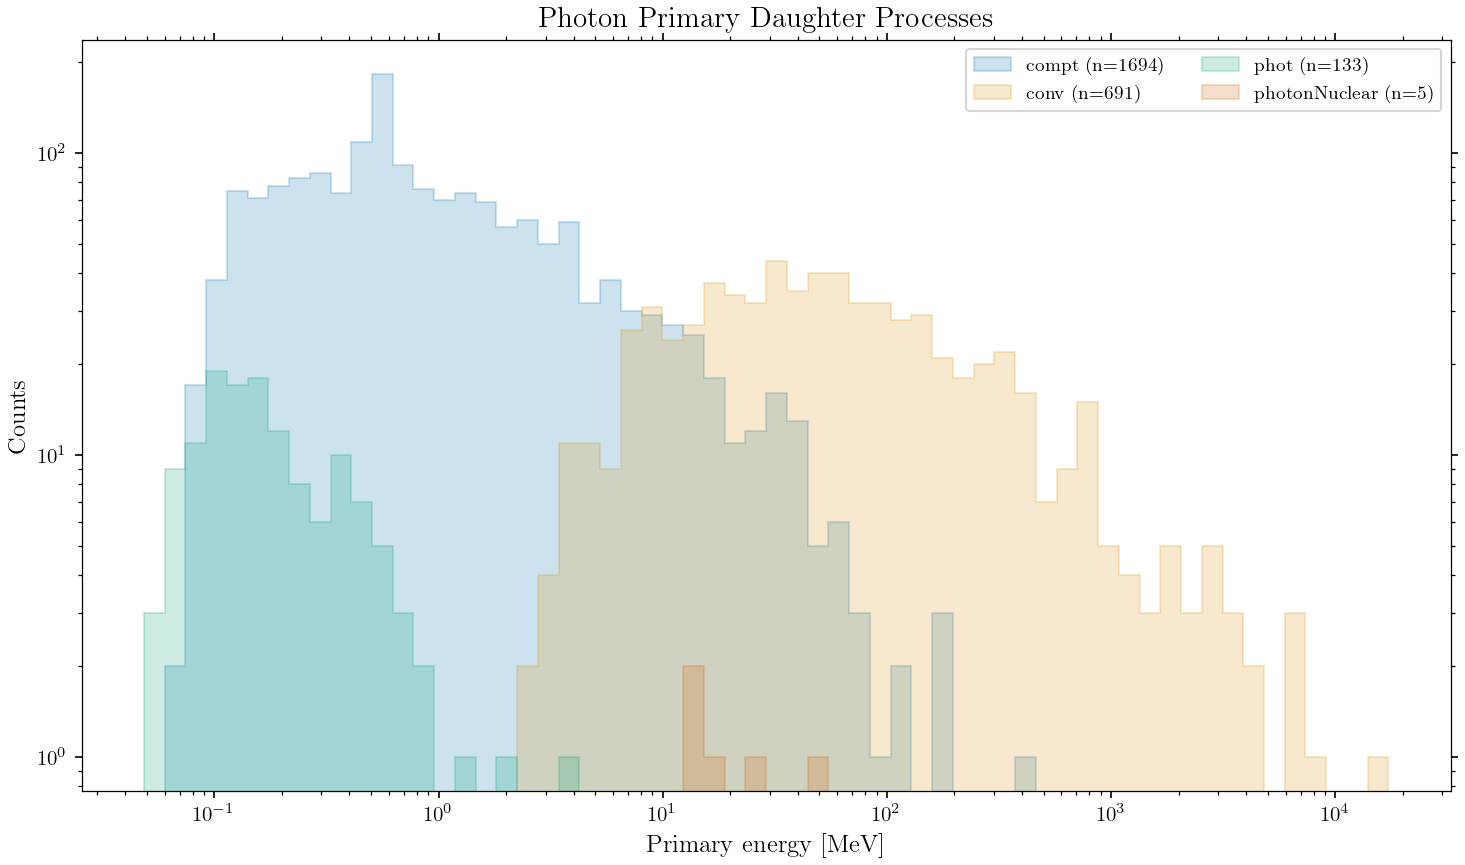

In [14]:
labels = sorted(energies_by_process.keys())

def clean(arr):
    a = np.asarray(arr, dtype=float)
    a = a[np.isfinite(a)]
    a = a[a > 0.0]
    return a

data = [clean(energies_by_process[l]) for l in labels]
valid = [c for c in data if c.size > 0]
energies = np.concatenate(valid)

# 2) define log-spaced bins
emin = max(np.min(energies), 1e-12)
emax = np.max(energies)
nbins = 61
bins = np.geomspace(emin, emax, nbins)

# 3) plot overlays with transparency
plt.figure(figsize=(10, 6))

for i, (label, Es) in enumerate(zip(labels, data)):
    if Es.size == 0:
        continue
    plt.hist(
        Es,
        bins=bins,
        histtype="stepfilled",
        alpha=0.2,
        color=colors[i % len(colors)],
        edgecolor=colors[i % len(colors)],
        linewidth=1.0,
        label=f"{label} (n={len(Es)})",
        density=False,
    )
    # plt.hist(
    #     Es,
    #     bins=bins,
    #     histtype="step",
    #     color=colors[i % len(colors)],
    #     linewidth=1.2,
    # )

plt.loglog()
plt.xlabel("Primary energy [MeV]")
plt.ylabel("Counts")
plt.title(f"Photon Primary Daughter Processes")
plt.legend(fontsize=9, ncol=2)
plt.tight_layout()
# plt.savefig("primary_involved_process_vs_primary_energy_overlay_logx.png", dpi=150)

plt.show()


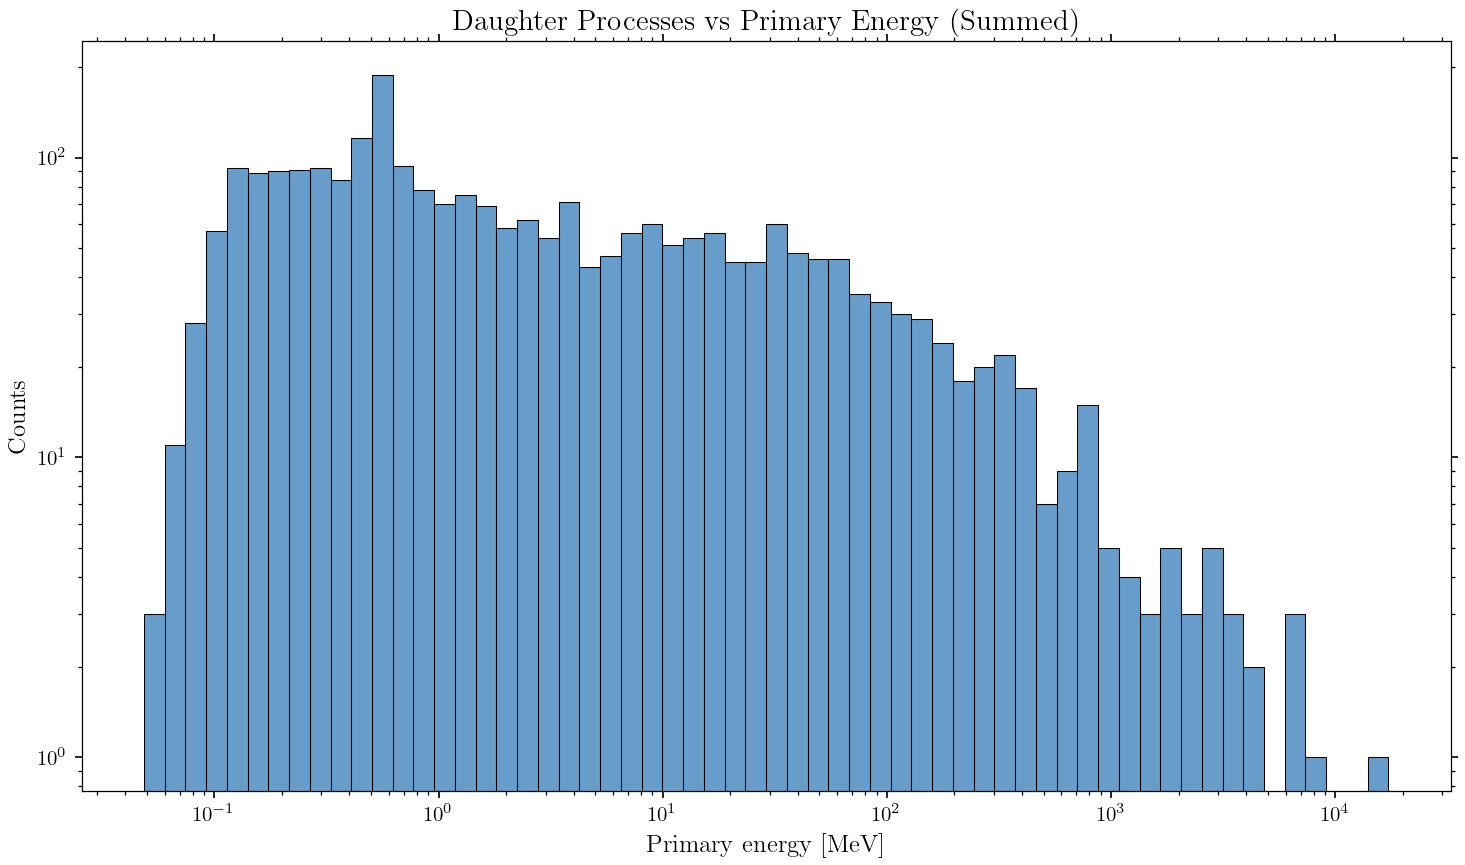

In [15]:
# plot summed histogram
plt.figure(figsize=(10, 6))
plt.hist(energies, bins=bins, color="#377EB8C1", edgecolor='black', lw=0.5)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Primary energy [MeV]")
plt.ylabel("Counts")
plt.title("Daughter Processes vs Primary Energy (Summed)")
plt.tight_layout()
# plt.savefig("primary_involved_process_vs_primary_energy_summed_loglog.png", dpi=
plt.show()

In [16]:
prim_energy_for_hit_events = []      # list of primary energies, one per event with ≥1 LArHit
event_to_primary_energy = {}

for entry in tree:
    event = tree.EventID.Index()

    # check if event has any MCLArHits
    has_hit = False
    for key, hit in tree.LArHits:
        has_hit = True
        break

    if not has_hit:
        continue  # skip events without any MCLArHits

    # find primary track in this event and take its initial energy
    primary_energy = None
    for trackID, track in tree.TrackList:
        if track.Process() == "Primary":
            traj = track.Trajectory()
            if len(traj) > 0:
                primary_energy = traj[0].momentum.E()
                break  # if only one primary is expected

    if primary_energy is not None:
        prim_energy_for_hit_events.append(primary_energy)
        event_to_primary_energy[event] = primary_energy

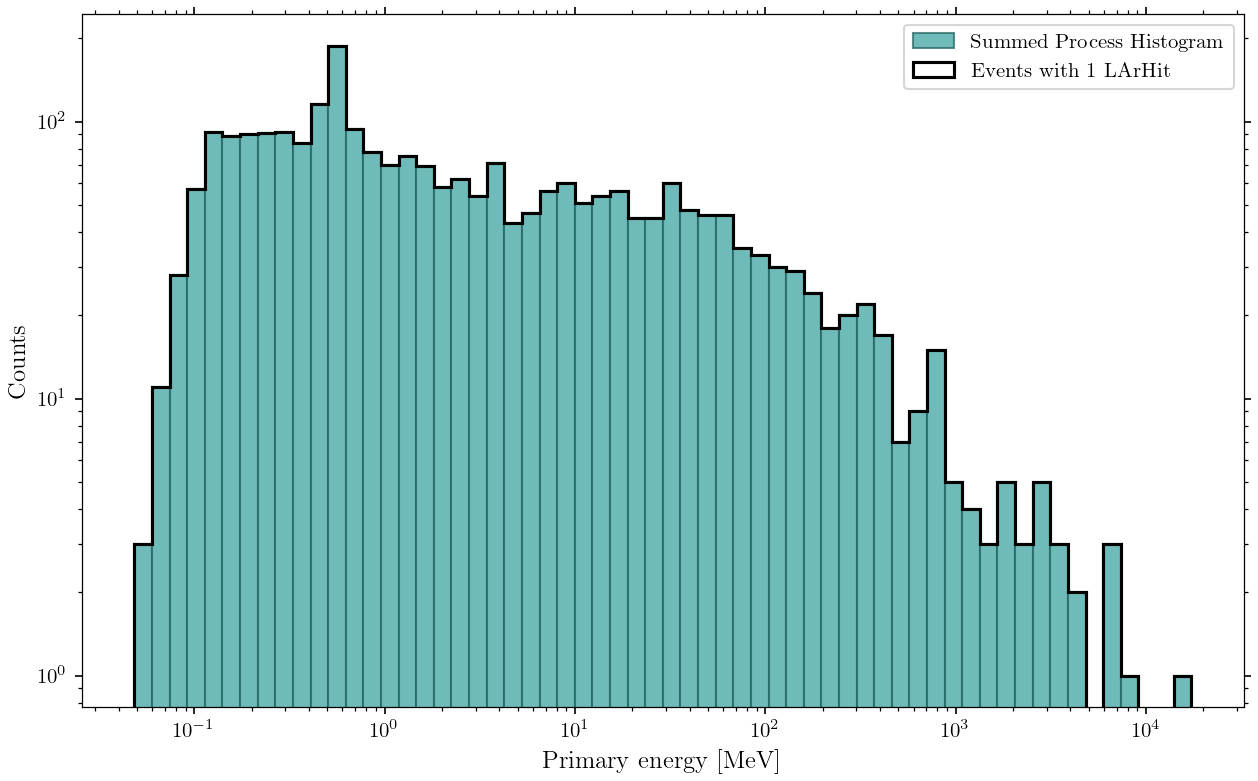

In [17]:
# plot event_to_primary_energy with the summed histogram data
plt.figure(figsize=(10, 6))
plt.hist(energies, bins=bins, color="#41A6A4C1", edgecolor="#2A6866C1", lw=1, label="Summed Process Histogram")

# plot the second histogram as black steps
plt.hist(prim_energy_for_hit_events, bins=bins, histtype='step', edgecolor='black', lw=1.5, label="Events with 1 LArHit")

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Primary energy [MeV]")
plt.ylabel("Counts")
plt.legend()
plt.show()